## Predicting the Sale Price of Bulldozers using Machine Learning
### 1. Problem Definition
How do we predict the future price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?
### 2. Data
The data is downloaded from the Kaggle bluebook for bulldozers competition
The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

https://www.kaggle.com/competitions/bluebook-for-bulldozers/data

### 3. Evaluation
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

### 4. Features
Kaggle provides a data dictionary  for the data features:


In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [260]:
# Import training and validation sets
df = pd.read_csv("data/TrainAndValid.csv", low_memory = False)

In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [262]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [263]:
df["saledate"][:1000].info

<bound method Series.info of 0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object>

<Axes: >

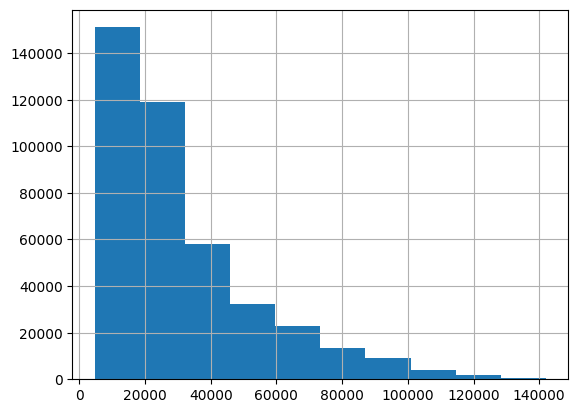

In [264]:
df["SalePrice"].hist()

### Parsing dates

When we work with time series data, we want to enrich the time and date component as much as possible

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter

In [265]:
# Import data agin but this time parse dates
df = pd.read_csv("data/TrainAndValid.csv", low_memory = False, parse_dates = ["saledate"] )
df["saledate"][:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

In [266]:
df["saledate"].info

<bound method Series.info of 0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]>

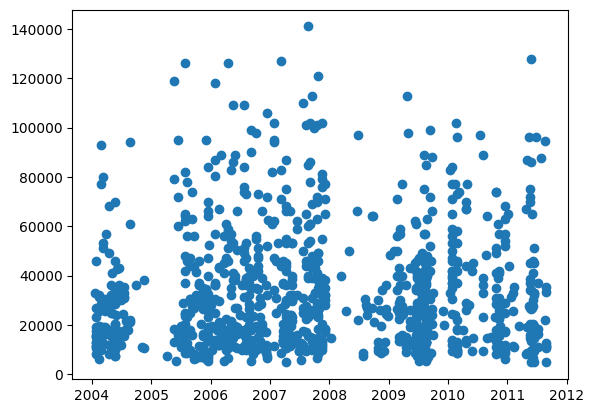

In [267]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [268]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


### Sort dataframe by saledate
When working  with time series data, it's a good idea to sort it by date

In [270]:
# Sort dataframe  in date order
df.sort_values(by=["saledate"], inplace = True, ascending = True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [271]:
#copy of the original DataFrame
df_tmp = df.copy()

In [272]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


#### Add datetime parameter for  `saledate` column

In [273]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [274]:
df_tmp.T

,205615,274835,141296,212552,62755,54653,81383,204924,135376,113390,...,409202,408976,411695,411319,408889,410879,412476,411927,407124,409203
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,...,6283634,6282337,6311321,6306476,6281219,6302984,6324811,6313029,6266251,6283635
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,...,35000.0,7500.0,13000.0,53000.0,39000.0,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,...,1930870,1928688,1823846,1278794,1792049,1915521,1919104,1918416,509560,1869284
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,...,4701,22072,17311,9114,13976,5266,19330,17244,3357,4701
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984,1976,1986,1970,1987,1966,...,1998,2005,2005,2004,2000,2001,2004,2004,1993,1000
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,...,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00


In [275]:
# Now we've enriched out dataframe with date time features, we can remove saledate
df_tmp.drop("saledate", axis = 1,  inplace = True)

### Converting String to Categories


In [276]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

False

In [277]:
# Find the columns that contain string
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

fiModelDesc
fiBaseModel
fiProductClassDesc
state
ProductGroup
ProductGroupDesc


In [278]:
# Turn all the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [279]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   object  
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  object  
 12  fiModelSeries             58667 non-null   object  
 13  fiModelDescriptor         748

In [280]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [281]:
# Check Missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save Preprocessed Data

In [282]:

# Export current tmp dataframe
df_tmp.to_csv('data/train_tmp.csv', index = False)

In [283]:
# Import preprocessed data
df_tmp = pd.read_csv('data/train_tmp.csv', low_memory = False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


## Fill Missing Values
### Filling numeric missing values


In [284]:
for label, conten in df_tmp.items():
    if  pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [285]:
df_tmp.Hydraulics.value_counts()

Hydraulics
2 Valve                145317
Standard               106515
Auxiliary               43224
Base + 1 Function       25511
3 Valve                  5807
4 Valve                  3077
Base + 3 Function         311
Base + 2 Function         132
Base + 5 Function          94
Base + 4 Function          81
Base + 6 Function          54
None or Unspecified        10
Name: count, dtype: int64

In [286]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [287]:
# Fill numeric rows with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary columns that tells is if the data is missing
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(conten.median())

In [288]:
# Check for which numeric columns have null values again
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

### Filling and turning categorical variables into numbers

In [289]:
# Check for columns which are not numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)


UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [290]:
# turn categorical variables into numbers and fill missing
for label, content in df_tmp.items(): 
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary coliumn to indicate whether the sample had missing values
        df_tmp[label + "_is_missing"] = pd.isnull(content)
        # turn categories into numbers and add +1 (to make it all pisitive)
        df_tmp[label] = pd.Categorical(content).codes + 1

In [291]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [292]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [293]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


### Modeling

In [ ]:
df_tmp["saleYear"].value_counts()

In [298]:
## Split data into Training and validation
df_val = df_tmp[df_tmp['saleYear'] == 2012]
df_train = df_tmp[df_tmp['saleYear'] != 2012]
len(df_val), len(df_train)

(11573, 401125)

In [299]:
# Spliting into X and y
X_train = df_train.drop("SalePrice", axis =1)
y_train = df_train["SalePrice"]
X_valid = df_val.drop("SalePrice", axis =1 )
y_valid = df_val['SalePrice']

In [305]:
# Reordoer the index of the training and valid data so that that are in the same order
X_train = X_train.sort_index(axis=1)
X_valid = X_valid.sort_index(axis=1)

In [306]:
X_train.head().T

,0,1,2,3,4
Backhoe_Mounting,1,0,1,0,1
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Extension,0,0,0,0,0
Blade_Extension_is_missing,True,True,True,True,True
Blade_Type,8,0,8,0,6
...,...,...,...,...,...
saleDayOfYear,17,31,31,31,31
saleMonth,1,1,1,1,1
saleYear,1989,1989,1989,1989,1989
state,44,9,9,9,9


In [307]:
X_valid.head().T

,401125,401126,401127,401128,401129
Backhoe_Mounting,1,0,0,0,0
Backhoe_Mounting_is_missing,False,True,True,True,True
Blade_Extension,0,1,0,0,0
Blade_Extension_is_missing,True,False,True,True,True
Blade_Type,5,0,0,0,0
...,...,...,...,...,...
saleDayOfYear,1,4,4,4,4
saleMonth,1,1,1,1,1
saleYear,2012,2012,2012,2012,2012
state,22,9,15,24,24


In [309]:
%%time
# Train the model
model.fit(X, y)

CPU times: total: 19min 53s
Wall time: 1min 59s


RandomForestRegressor(n_jobs=-1, random_state=42)

#### Building an Evaluation Function

In [310]:
# Create avaluation function (RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
def rmsle (y_test, y_preds):
    """
    Calculate root mean squared log error between predictions and true lables
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))


def show_score(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Train MAE": mean_absolute_error(y_train, train_preds),
             "Valid_MAE": mean_absolute_error(y_valid, val_preds),
             "Training RMSLE": rmsle(y_train, train_preds),
             "Valid RMSLE": rmsle(y_valid, val_preds),
             "Training R^2": r2_score(y_train, train_preds),
             "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

## Reducing sample size to speed up training 

In [312]:
## Change max_sample value
model = RandomForestRegressor(n_jobs = -1, random_state = 42, max_samples = 10000)

In [313]:
%%time
model.fit(X_train, y_train)

CPU times: total: 44.8 s
Wall time: 4.73 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [314]:
show_score(model)

{'Train MAE': 5560.788059033966,
 'Valid_MAE': 7173.600794953772,
 'Training RMSLE': 0.25777215730093467,
 'Valid RMSLE': 0.29277466298777394,
 'Training R^2': 0.8607464159601093,
 'Valid R^2': 0.8320292993776166}

#### Hyperparameter  tuning

In [315]:
%%time 
import numpy as np
from sklearn.model_selection  import RandomizedSearchCV
rf_grid ={"n_estimators": np.arange(10, 500, 10),
          "max_depth": [None, 3,5, 10],
          "min_samples_split": np.arange(2, 20,2),
          "min_samples_leaf": np.arange(2,20,2),
          "max_features": [0.5, 1, "sqrt", "auto"],
          "max_samples": [10000],
          "bootstrap": [True, False] } 
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1, 
                                                   random_state = 42), 
                                                   param_distributions = rf_grid,
                                                   n_iter = 200,
                                                   cv = 5, verbose = True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\tranh\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
665 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
310 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tranh\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tranh\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\tranh\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py", line 638, in _validate_params
    validat

CPU times: total: 53min 41s
Wall time: 9min 52s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=200,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490])},
                   verbose=True)

In [316]:
# Best hyperparameter from RandomizedSearchCV
rs_model.best_params_

{'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None,
 'bootstrap': True}

In [317]:
show_score(model)

{'Train MAE': 5560.788059033966,
 'Valid_MAE': 7173.600794953772,
 'Training RMSLE': 0.25777215730093467,
 'Valid RMSLE': 0.29277466298777394,
 'Training R^2': 0.8607464159601093,
 'Valid R^2': 0.8320292993776166}

### Train a model with the best hyperparameters from RandomizedSearchCV

In [318]:
%%time
# most ideal model
final_model = RandomForestRegressor(n_estimators = 200,
                                    min_samples_split = 6,
                                    min_samples_leaf =  2,
                                    max_samples = None,
                                    max_features = 0.5,
                                    max_depth = None,
                                    n_jobs = -1,
                                    random_state = 40
                                   )
# fit the model
final_model.fit(X_train, y_train)

CPU times: total: 16min 2s
Wall time: 1min 31s


RandomForestRegressor(max_features=0.5, min_samples_leaf=2, min_samples_split=6,
                      n_estimators=200, n_jobs=-1, random_state=40)

In [319]:
# score for the ideal model (train on all the data)
show_score(final_model)

{'Train MAE': 2271.139007742551,
 'Valid_MAE': 5878.832024872474,
 'Training RMSLE': 0.11739168928433531,
 'Valid RMSLE': 0.24287625893236486,
 'Training R^2': 0.9736336282894162,
 'Valid R^2': 0.8840194245522761}

In [320]:
# score for the final model (train on 10000 samples)
show_score(rs_model)

{'Train MAE': 5779.934224771272,
 'Valid_MAE': 7148.990698186048,
 'Training RMSLE': 0.26545988723493474,
 'Valid RMSLE': 0.2942360104281623,
 'Training R^2': 0.851005286522805,
 'Valid R^2': 0.835093363285177}

### Make Predictions on test data
#### Preprocessing the test data

In [323]:
#import test set
test_df = pd.read_csv("data/Test.csv", low_memory =  False,
                     parse_dates = ["saledate"])


In [325]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [326]:
test_df = preprocess_data(test_df)

In [332]:
# Reorder the index of the test data
test_df = test_df.sort_index(axis = 1)

In [333]:
test_df.head()

,Backhoe_Mounting,Backhoe_Mounting_is_missing,Blade_Extension,Blade_Extension_is_missing,Blade_Type,Blade_Type_is_missing,Blade_Width,Blade_Width_is_missing,Coupler,Coupler_System,...,fiProductClassDesc_is_missing,fiSecondaryDesc,fiSecondaryDesc_is_missing,saleDay,saleDayOfWeek,saleDayOfYear,saleMonth,saleYear,state,state_is_missing
0,0,True,0,True,0,True,0,True,0,0,...,False,25,False,3,3,124,5,2012,51,False
1,0,True,0,True,0,True,0,True,3,0,...,False,0,True,10,3,131,5,2012,46,False
2,0,True,0,True,0,True,0,True,3,0,...,False,9,False,10,3,131,5,2012,29,False
3,0,True,0,True,0,True,0,True,3,0,...,False,13,False,10,3,131,5,2012,29,False
4,1,False,0,True,4,False,0,True,0,0,...,False,33,False,10,3,131,5,2012,8,False


In [334]:
 set(X_train.columns) - set(test_df.columns) 

set()

In [329]:
# Manually adjust test_df to have autioneedID and saledate_is_missing columns
test_df["auctioneerID_is_missing"] = False


In [330]:
 set(X_train.columns) - set(test_df.columns) 

set()

In [335]:
test_preds = final_model.predict(test_df)

In [336]:
test_preds

array([17073.19064755, 16523.89292929, 50037.58387446, ...,
       12910.33203741, 16893.61917388, 27241.25364913])

In [338]:
len(test_preds), len(test_df)

(12457, 12457)

#### Format predictions  for submission

In [341]:
preds_df = pd.DataFrame()
preds_df["SalesID"] = test_df["SalesID"]
preds_df["SalePrice"] = test_preds
preds_df

,SalesID,SalePrice
0,1227829,17073.190648
1,1227844,16523.892929
2,1227847,50037.583874
3,1227848,66395.126838
4,1227863,53874.439665
...,...,...
12452,6643171,39888.301587
12453,6643173,11904.583333
12454,6643184,12910.332037
12455,6643186,16893.619174


In [343]:
## Save the submission
preds_df.to_csv("data/Prediction", index = False)